## DA Lab project
### Pratyay Piyush Mishra
### DA25E053

In [7]:
import numpy as np
import pandas as pd


In [10]:
import json
selector = 'train'
file_path = f'{selector}_data.json'

with open(file_path, 'r') as f:
    data_array = json.load(f)

In [ ]:
from huggingface_hub import login
login() # This will prompt for your token if not set as a Colab secret

#### Embedding generation

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the model
model_id = "google/embeddinggemma-300m"
model = SentenceTransformer(model_id)

# --- Your labeled data example ---

input_prompt = [f"System: {item.get('system_prompt')}\nUser: {item.get('user_prompt')}" if item.get('system_prompt') else f"User: {item.get('user_prompt')}" for item in data_array]
ai_response = [f"{item.get('response')}." for item in data_array]
# ----------------------------------

In [ ]:
prompt_emb = model.encode(
    input_prompt,
    prompt_name="STS", # Use "STS" for all similarity-related tasks
    convert_to_numpy=True
)

In [ ]:
response_emb = model.encode(
    ai_response,
    prompt_name="STS", # Use "STS" for all similarity-related tasks
    convert_to_numpy=True
)

In [ ]:
np.save("prompt_emb_train1",response_emb)
np.save("response_emb_train1",response_emb)

In [11]:
metric_embeddings = np.load('train_metric_embeddings.npy')
response_emb = np.load('response_emb_train1.npy')
prompt_emb = np.load('prompt_emb_train1.npy')

### Creating dataframe with prompt, response, and metric embeddings

##### PS. Note that train_metric_embeddings.npy and test_metric_embeddings.npy are created using given metric name in json data and selecting corresponding metric from given metric_name_embeddings.npy

#### Helper function to add embeddings to df

In [12]:
import pandas as pd
import numpy as np

n = 64

def add_emb_df(df,emb_array,emb_name):
  emb_columns = [f'{emb_name}{i}' for i in range(n)]

  # Create a DataFrame from the prompt_emb array
  emb_df = pd.DataFrame(emb_array[:,:n], columns=emb_columns)
  # print(emb_df.head())

  # Concatenate the new prompt_emb_df with the existing df
  # Make sure both DataFrames have the same index for correct concatenation
  df = pd.concat([df, emb_df], axis=1)
  return df


In [13]:
metric_list = [item.get('metric_name') for item in data_array]

#### Cosine similarity between given embedding pairs

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_vector_prompt_response = cosine_similarity(prompt_emb, response_emb).diagonal()
similarity_vector_metric_response = cosine_similarity(metric_embeddings, response_emb).diagonal()
similarity_vector_metric_prompt = cosine_similarity(metric_embeddings, prompt_emb).diagonal()
# print("Shape of the new similarity vector:", similarity_vector_prompt_response.shape)
# print("First 5 elements of the similarity vector:", similarity_vector_prompt_response[:5])

### Scaled scores to bins as described in report

In [15]:
d = pd.read_csv('train_scores.csv',header=None)
scores = d[0].to_numpy()
scores_ = scores.copy()
for i in range(len(scores_)):
  if scores_[i]<=4:
    scores_[i]=0
  elif scores_[i]<=7:
    scores_[i]=1
  else:
    scores_[i]=2

#### Skewed data distribution

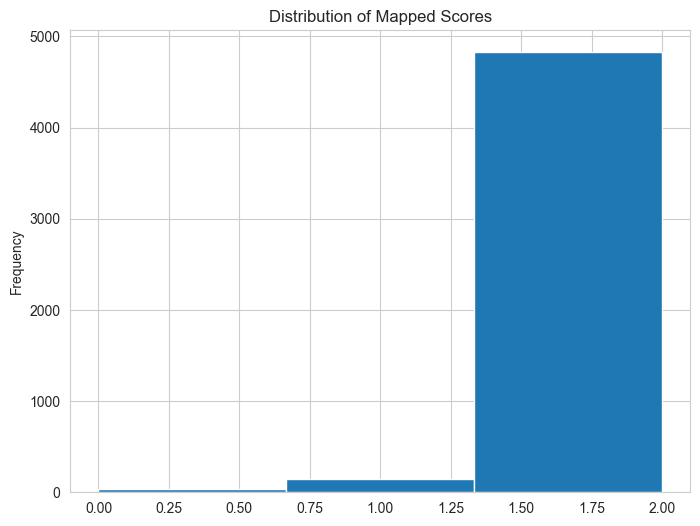

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(8, 6))
plt.hist(scores_,bins=3)
plt.title('Distribution of Mapped Scores')
plt.ylabel('Frequency')
plt.show()

#### Created DF from cosine similarities and their products. Added embeddings to the df

In [17]:
df = pd.DataFrame({
    'prompt_response_similarity':similarity_vector_prompt_response,
    'metric_response_similarity':similarity_vector_metric_response,
    'metric_prompt_similarity':similarity_vector_metric_prompt,
    'prod':similarity_vector_prompt_response*similarity_vector_metric_response,
    'prod2':similarity_vector_prompt_response*similarity_vector_metric_prompt,
    'prod3':similarity_vector_metric_response*similarity_vector_metric_prompt,

    # 'metric':metric_list,
    'score':scores_
})

In [18]:
df = add_emb_df(df,metric_embeddings,'metric_')
df = add_emb_df(df,prompt_emb,'prompt_')
df = add_emb_df(df,response_emb,'response_')
df.shape

(5000, 199)

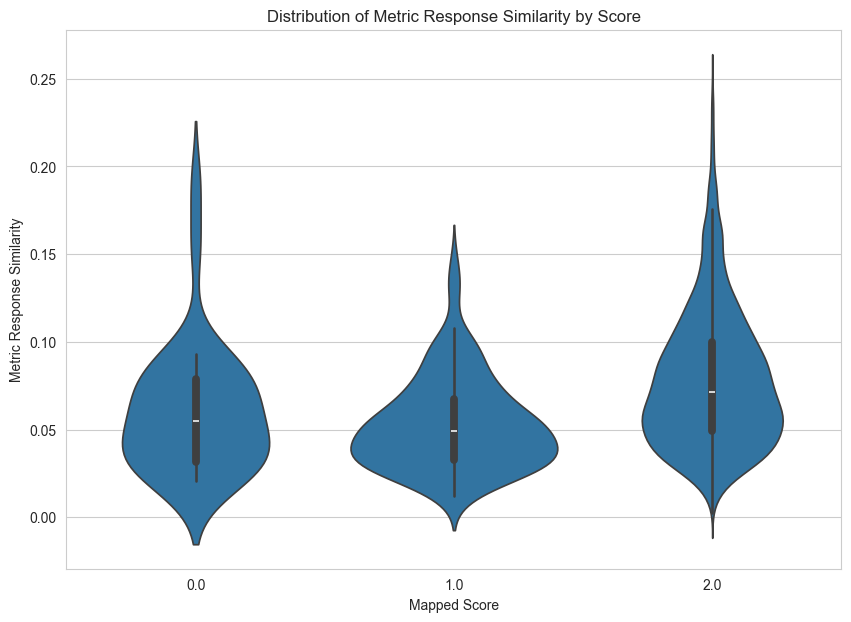

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create the violin plot
plt.figure(figsize=(10, 7))
sns.violinplot(x='score', y='prod3', data=df)

# Add labels and title
plt.title('Distribution of Metric Response Similarity by Score')
plt.xlabel('Mapped Score')
plt.ylabel('Metric Response Similarity') # Ensure x-axis labels match mapped scores

# Display the plot
plt.show()

### Logistic model with class weighted samples

Calculated Class Weights for Logistic Regression: {np.float64(0.0): np.float64(49.01960784313726), np.float64(1.0): np.float64(11.82033096926714), np.float64(2.0): np.float64(0.3454231433506045)}

Shape of X_train_lr: (4000, 198)
Shape of y_train_lr: (4000,)
Shape of sample_weight_train_lr: (4000,)
Shape of X_test_lr: (1000, 198)
Shape of y_test_lr: (1000,)
Shape of sample_weight_test_lr: (1000,)

Training Weighted Logistic Regression model...


/Users/pratyaypiyushmishra/Desktop/da_lab_final_proj/.v/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Weighted Logistic Regression model training complete.

Weighted Logistic Regression Classification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.80      0.71      0.75 343.1372549019608
         1.0       0.45      0.43      0.44 330.96926713947994
         2.0       0.57      0.67      0.62 333.3333333333387

    accuracy                           0.60 1007.4398553747794
   macro avg       0.61      0.60      0.60 1007.4398553747794
weighted avg       0.61      0.60      0.61 1007.4398553747794



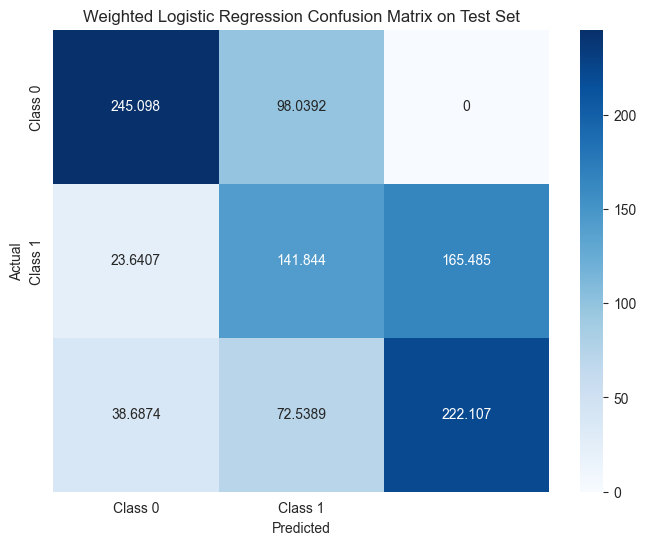

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define features (X_lr) and target (y_lr) from the df
X_lr = df.drop(['score'],axis=1)
y_lr = df['score']

# Calculate class weights for y_lr
# Assuming y_lr contains only 0s and 1s as mapped earlier
unique_classes_lr, counts_lr = np.unique(y_lr, return_counts=True)
total_samples_lr = np.sum(counts_lr)

class_weights_lr = {}
for i, class_label_lr in enumerate(unique_classes_lr):
    weight_lr = total_samples_lr / (len(unique_classes_lr) * counts_lr[i])
    class_weights_lr[class_label_lr] = weight_lr

print(f"Calculated Class Weights for Logistic Regression: {class_weights_lr}")

# Generate sample weights for each instance based on its score
sample_weights_lr = np.array([class_weights_lr[s] for s in y_lr])

# Split the data into training and test sets, stratifying by y_lr
X_train_lr, X_test_lr, y_train_lr, y_test_lr, sample_weight_train_lr, sample_weight_test_lr = train_test_split(
    X_lr, y_lr, sample_weights_lr, test_size=0.2, random_state=42, stratify=y_lr
)

print(f"\nShape of X_train_lr: {X_train_lr.shape}")
print(f"Shape of y_train_lr: {y_train_lr.shape}")
print(f"Shape of sample_weight_train_lr: {sample_weight_train_lr.shape}")
print(f"Shape of X_test_lr: {X_test_lr.shape}")
print(f"Shape of y_test_lr: {y_test_lr.shape}")
print(f"Shape of sample_weight_test_lr: {sample_weight_test_lr.shape}")

# Initialize and Train Weighted Logistic Regression model
print("\nTraining Weighted Logistic Regression model...")
logistic_reg_model = LogisticRegression(random_state=42, solver='liblinear') # liblinear for small datasets and L1/L2 regularization
logistic_reg_model.fit(X_train_lr, y_train_lr, sample_weight=sample_weight_train_lr)
print("Weighted Logistic Regression model training complete.")

# Make predictions on the test set
y_pred_lr = logistic_reg_model.predict(X_test_lr)

# Evaluate the model
print("\nWeighted Logistic Regression Classification Report on Test Set:\n", classification_report(y_test_lr, y_pred_lr, sample_weight=sample_weight_test_lr))

# Generate Confusion Matrix
cm_lr = confusion_matrix(y_test_lr, y_pred_lr, sample_weight=sample_weight_test_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Weighted Logistic Regression Confusion Matrix on Test Set')
plt.show()

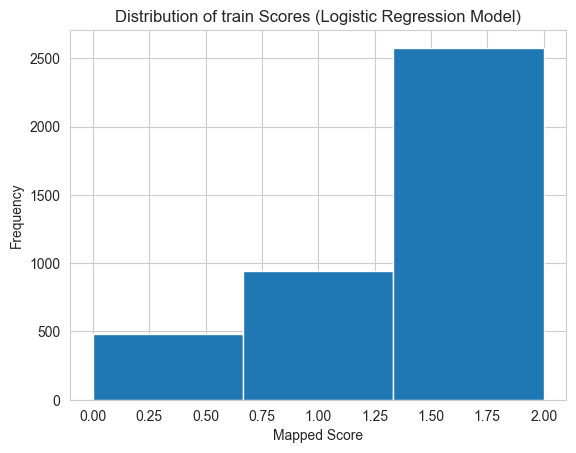

In [40]:
y_pred_ = logistic_reg_model.predict(X_train_lr)
plt.hist(y_pred_,bins=3)
plt.title('Distribution of train Scores (Logistic Regression Model)')
plt.xlabel('Mapped Score')
plt.ylabel('Frequency')
plt.show()


#### Created test dataframe from given test data

In [22]:
metric_embeddings = np.load('test_metric_embeddings.npy')
response_emb = np.load('response_emb_test1.npy')
prompt_emb = np.load('prompt_emb_test1.npy')

In [23]:
similarity_vector_prompt_response = cosine_similarity(prompt_emb, response_emb).diagonal()
similarity_vector_metric_response = cosine_similarity(metric_embeddings, response_emb).diagonal()
similarity_vector_metric_prompt = cosine_similarity(metric_embeddings, prompt_emb).diagonal()


In [24]:
df = pd.DataFrame({
    'prompt_response_similarity':similarity_vector_prompt_response,
    'metric_response_similarity':similarity_vector_metric_response,
    'metric_prompt_similarity':similarity_vector_metric_prompt,
    'prod':similarity_vector_prompt_response*similarity_vector_metric_response,
    'prod2':similarity_vector_prompt_response*similarity_vector_metric_prompt,
    'prod3':similarity_vector_metric_response*similarity_vector_metric_prompt,
    # 'metric':metric_list,
    # 'score':scores_
})

In [25]:
df = add_emb_df(df,metric_embeddings,'metric_')
df = add_emb_df(df,prompt_emb,'prompt_')
df = add_emb_df(df,response_emb,'response_')
df.shape

(3638, 198)

#### Predicted y class on test data

Distribution of Predicted Scores for test_emb (Logistic Regression model):
Score 0.0: 1184 occurrences
Score 1.0: 1080 occurrences
Score 2.0: 1374 occurrences


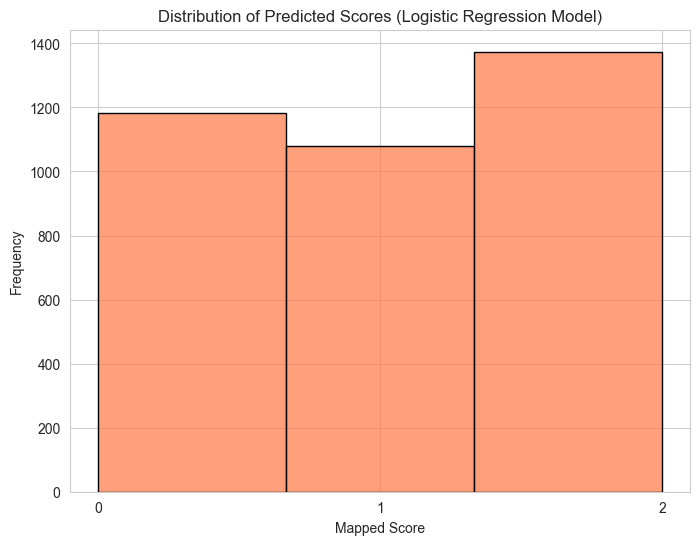

In [26]:
y_pred_test_lr = logistic_reg_model.predict(df)

# Show the distribution of predicted scores
unique_pred_test_lr, counts_pred_test_lr = np.unique(y_pred_test_lr, return_counts=True)
print("Distribution of Predicted Scores for test_emb (Logistic Regression model):")
for score, count in zip(unique_pred_test_lr, counts_pred_test_lr):
    print(f"Score {score}: {count} occurrences")

# Optionally, visualize the distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(8, 6))
sns.histplot(y_pred_test_lr, bins=3, kde=False, color='coral', edgecolor='black')
plt.title('Distribution of Predicted Scores (Logistic Regression Model)')
plt.xlabel('Mapped Score')
plt.ylabel('Frequency')
plt.xticks(unique_pred_test_lr)
plt.show()

In [41]:
import pandas as pd
import numpy as np

# Scale the y_pred_test_lr values
scaled_scores = [0]*len(y_pred_test_lr)
for i in range(len(y_pred_test_lr)):
  if y_pred_test_lr[i]==0:
    scaled_scores[i]=4
  elif y_pred_test_lr[i]==1:
    scaled_scores[i]=6
  else:
    scaled_scores[i]=7
# Create a DataFrame with 'ID' and 'score' columns
output_df = pd.DataFrame({
    'ID': np.arange(1, len(scaled_scores) + 1),
    'score': scaled_scores
})

# Display the head of the new DataFrame
print("New DataFrame created:")
print(output_df.head())
print(output_df.shape)

New DataFrame created:
   ID  score
0   1      7
1   2      6
2   3      4
3   4      7
4   5      6
(3638, 2)


#### This model had ~3.8 RMSE on kaggle

In [28]:
output_df.to_csv('output_predictions.csv', index=False)
print("Predicted scores saved to 'output_predictions.csv'")

Predicted scores saved to 'output_predictions.csv'


### BalancedRandomForestClassifier

In [30]:
from imblearn.ensemble import BalancedRandomForestClassifier
print("BalancedRandomForestClassifier imported successfully.")

BalancedRandomForestClassifier imported successfully.


In [31]:
print("\nTraining Weighted BalancedRandomForestClassifier model...")
balanced_rf_model = BalancedRandomForestClassifier(random_state=42, class_weight=class_weights_lr) # Use the calculated class weights
balanced_rf_model.fit(X_train_lr, y_train_lr)
print("Weighted BalancedRandomForestClassifier model training complete.")


Training Weighted BalancedRandomForestClassifier model...
Weighted BalancedRandomForestClassifier model training complete.


In [32]:
y_pred_brf = balanced_rf_model.predict(X_test_lr)
print("Predictions made on the test set using BalancedRandomForestClassifier.")

Predictions made on the test set using BalancedRandomForestClassifier.


### Model performance and confusion matrix


Weighted BalancedRandomForestClassifier Classification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.71      0.57      0.63 343.1372549019608
         1.0       0.59      0.50      0.54 330.96926713947994
         2.0       0.52      0.71      0.60 333.3333333333387

    accuracy                           0.59 1007.4398553747794
   macro avg       0.61      0.59      0.59 1007.4398553747794
weighted avg       0.61      0.59      0.59 1007.4398553747794



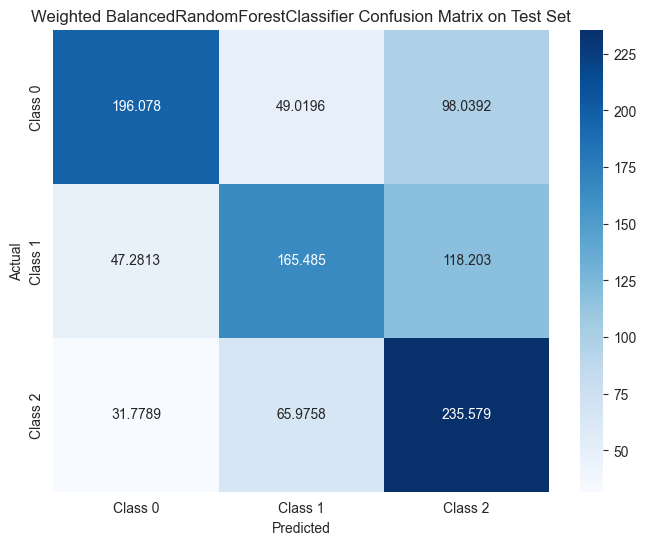

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model
print("\nWeighted BalancedRandomForestClassifier Classification Report on Test Set:\n", classification_report(y_test_lr, y_pred_brf, sample_weight=sample_weight_test_lr))

# Generate Confusion Matrix
cm_brf = confusion_matrix(y_test_lr, y_pred_brf, sample_weight=sample_weight_test_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_brf, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Weighted BalancedRandomForestClassifier Confusion Matrix on Test Set')
plt.show()

#### Tuned Prediction Thresholds for Minority Classes using F1-score


In [34]:
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score

# 1. Get prediction probabilities for X_test_lr
y_pred_proba_brf = balanced_rf_model.predict_proba(X_test_lr)

# 2. Define a range of thresholds to test for class 0 and class 1
# Using np.arange for a step of 0.05 from 0.1 to 0.85 (inclusive).
thresholds_0 = np.arange(0.1, 0.9, 0.05)
thresholds_1 = np.arange(0.1, 0.9, 0.05)

best_f1 = -1
best_balanced_accuracy = -1
optimal_thresholds = {'t0': 0, 't1': 0}
results = []

# Convert y_test_lr to integer type for metric compatibility
y_true_int = y_test_lr.astype(int)

# 3. Create nested loops to iterate through all combinations of thresholds
print("Tuning thresholds for minority classes...")
for t0 in thresholds_0:
    for t1 in thresholds_1:
        # Initialize an array for adjusted predictions
        adjusted_preds = np.empty_like(y_true_int, dtype=int)

        # 4. For each pair of thresholds, adjust predictions
        for i in range(len(y_pred_proba_brf)):
            probs = y_pred_proba_brf[i]

            # Prioritize class 0 if its probability exceeds its threshold
            if probs[0] >= t0:
                adjusted_preds[i] = 0
            # If not class 0, check for class 1 if its probability exceeds its threshold
            elif probs[1] >= t1:
                adjusted_preds[i] = 1
            # Otherwise, use the original argmax prediction
            else:
                adjusted_preds[i] = np.argmax(probs)

        # d. Evaluate the performance using weighted F1-score and balanced accuracy
        current_f1 = f1_score(y_true_int, adjusted_preds, average='weighted', sample_weight=sample_weight_test_lr)
        current_balanced_accuracy = balanced_accuracy_score(y_true_int, adjusted_preds, sample_weight=sample_weight_test_lr)

        results.append({
            'threshold_0': t0,
            'threshold_1': t1,
            'f1_score': current_f1,
            'balanced_accuracy': current_balanced_accuracy
        })

        # Keep track of the best performance
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_balanced_accuracy = current_balanced_accuracy # Update balanced accuracy with the best F1
            optimal_thresholds['t0'] = t0
            optimal_thresholds['t1'] = t1

# 5. Identify and print the optimal thresholds and their corresponding scores
print("\nThreshold tuning complete.")
print("Optimal Thresholds found based on Weighted F1-score:")
print(f"  Threshold for Class 0 (t0): {optimal_thresholds['t0']:.2f}")
print(f"  Threshold for Class 1 (t1): {optimal_thresholds['t1']:.2f}")
print(f"  Best Weighted F1-score: {best_f1:.4f}")
print(f"  Corresponding Balanced Accuracy: {best_balanced_accuracy:.4f}")

Tuning thresholds for minority classes...

Threshold tuning complete.
Optimal Thresholds found based on Weighted F1-score:
  Threshold for Class 0 (t0): 0.35
  Threshold for Class 1 (t1): 0.50
  Best Weighted F1-score: 0.6346
  Corresponding Balanced Accuracy: 0.6352


## Final Evaluation with Best Thresholds


Final predictions generated using optimal thresholds.

Classification Report with Optimal Thresholds:
               precision    recall  f1-score   support

           0       0.74      0.71      0.73 343.1372549019608
           1       0.59      0.50      0.54 330.96926713947994
           2       0.58      0.69      0.63 333.3333333333387

    accuracy                           0.64 1007.4398553747794
   macro avg       0.64      0.64      0.63 1007.4398553747794
weighted avg       0.64      0.64      0.63 1007.4398553747794



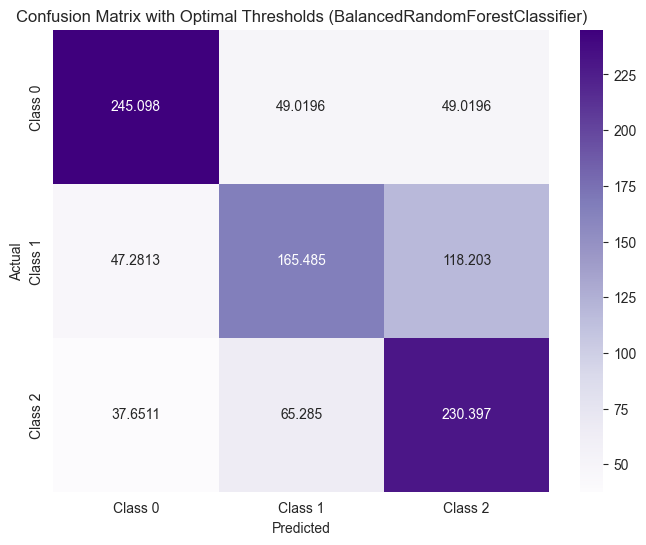

In [35]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Use the prediction probabilities (y_pred_proba_brf) from the balanced_rf_model on X_test_lr.
#    (This variable was already generated in the previous step: y_pred_proba_brf)

# 2. Create an empty array, final_adjusted_preds, to store the adjusted predicted classes
final_adjusted_preds = np.empty_like(y_test_lr, dtype=int)

# Get optimal thresholds
t0_opt = optimal_thresholds['t0']
t1_opt = optimal_thresholds['t1']

# Convert y_test_lr to integer type for metric compatibility
y_true_int = y_test_lr.astype(int)

# 3. Iterate through each sample's prediction probabilities in y_pred_proba_brf.
# 4. For each sample, apply the optimal_thresholds to determine the final predicted class:
for i in range(len(y_pred_proba_brf)):
    probs = y_pred_proba_brf[i]

    # a. If the probability for class 0 is greater than or equal to optimal_thresholds['t0'], set the predicted class to 0.
    if probs[0] >= t0_opt:
        final_adjusted_preds[i] = 0
    # b. Else, if the probability for class 1 is greater than or equal to optimal_thresholds['t1'], set the predicted class to 1.
    elif probs[1] >= t1_opt:
        final_adjusted_preds[i] = 1
    # c. Otherwise, set the predicted class to the one with the highest probability (using np.argmax).
    else:
        final_adjusted_preds[i] = np.argmax(probs)

print("Final predictions generated using optimal thresholds.")

# 5. Print a classification report
print("\nClassification Report with Optimal Thresholds:\n", classification_report(y_true_int, final_adjusted_preds, sample_weight=sample_weight_test_lr))

# 6. Generate and display a confusion matrix
cm_final = confusion_matrix(y_true_int, final_adjusted_preds, sample_weight=sample_weight_test_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='g', cmap='Purples',
            xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Optimal Thresholds (BalancedRandomForestClassifier)')
plt.show()

## Predict and Save Test Data Scores

Mapped these predicted scores back to their original scale (e.g., 0->4, 1->6, 2->7) and saved the results to `output_predictions_balanced_rf.csv`.


In [36]:
import numpy as np
import pandas as pd

# 1. Predict probabilities for the entire test dataset (df)
y_pred_proba_test = balanced_rf_model.predict_proba(df)
print("Predicted probabilities for the test data (df) using BalancedRandomForestClassifier.")

Predicted probabilities for the test data (df) using BalancedRandomForestClassifier.


In [37]:
import numpy as np

# 2. Initialize an empty NumPy array to store adjusted predicted classes
final_test_preds = np.empty(len(df), dtype=int)

# 3. Retrieve the optimal thresholds for class 0 (t0_opt) and class 1 (t1_opt)
t0_opt = optimal_thresholds['t0']
t1_opt = optimal_thresholds['t1']

# 4. Iterate through each sample's prediction probabilities and apply the optimal threshold logic
for i in range(len(y_pred_proba_test)):
    probs = y_pred_proba_test[i]

    # a. If the probability for class 0 is greater than or equal to t0_opt, set the predicted class to 0.
    if probs[0] >= t0_opt:
        final_test_preds[i] = 0
    # b. Else, if the probability for class 1 is greater than or equal to t1_opt, set the predicted class to 1.
    elif probs[1] >= t1_opt:
        final_test_preds[i] = 1
    # c. Otherwise, set the predicted class to the one with the highest probability (using np.argmax).
    else:
        final_test_preds[i] = np.argmax(probs)

print("Adjusted predictions for the test data generated using optimal thresholds.")

Adjusted predictions for the test data generated using optimal thresholds.


In [38]:
import numpy as np

# 5. Create a new list or array, for example, `scaled_test_scores`, to store the mapped scores.
scaled_test_scores = np.empty_like(final_test_preds, dtype=float)

# Iterate through `final_test_preds` and map the values:
for i, pred_class in enumerate(final_test_preds):
    # a. If the predicted score is 0, map it to 4.
    if pred_class == 0:
        scaled_test_scores[i] = 4.0
    # b. If the predicted score is 1, map it to 5.5.
    elif pred_class == 1:
        scaled_test_scores[i] = 6
    # c. If the predicted score is 2, map it to 7.
    else:
        scaled_test_scores[i] = 7.0

print("Predicted classes mapped back to original score scale.")

Predicted classes mapped back to original score scale.


In [39]:
import pandas as pd
import numpy as np

# 6. Create a Pandas DataFrame with two columns: 'ID' and 'score'
output_df_balanced_rf = pd.DataFrame({
    'ID': np.arange(1, len(scaled_test_scores) + 1),
    'score': scaled_test_scores
})

# 7. Save the DataFrame to a CSV file named 'output_predictions_balanced_rf.csv'
output_df_balanced_rf.to_csv('output_predictions_balanced_rf.csv', index=False)

print("Predicted scores saved to 'output_predictions_balanced_rf.csv'")
print(output_df_balanced_rf.head())

Predicted scores saved to 'output_predictions_balanced_rf.csv'
   ID  score
0   1    7.0
1   2    6.0
2   3    6.0
3   4    7.0
4   5    7.0


#### This model had ~3.605 RMSE on kaggle and was our best performing model.